In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

from beautifultable import BeautifulTable as BT
# import pandas_profiling

from matplotlib import rcParams
import warnings

from sklearn.model_selection import train_test_split as separar
from sklearn.preprocessing import MinMaxScaler

%matplotlib notebook
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,7)

In [217]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [3]:
df.describe()

df['age'] = df['age'].astype(np.int64)
df['platelets'] = df['platelets'].astype(np.int64)
df['serum_creatinine'] = df['serum_creatinine'].astype(np.int64)

df.dtypes


profile = ProfileReport(df, title='Heart Failure', explorative=True, vars={"num": {"low_categorical_threshold": 0}} )
profile.to_file("tmp.html")
profile

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Los ceros corresponden a falsos y los unos a verdaderos
- edad: edad del paciente (años)
- anemia: disminución de glóbulos rojos o hemoglobina (booleana)
- presión arterial alta: si el paciente tiene hipertensión (booleano)
- creatinina fosfoquinasa (CPK): nivel de la enzima CPK en la sangre (mcg/L) valores muy lejanos, posibles outliers
- diabetes: si el paciente tiene diabetes (booleano)
- fracción de eyección: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- plaquetas: plaquetas en la sangre (kiloplaquetas/mL) posibles valores atipicos
- sexo: mujer u hombre (binario) (0 -> mujeres)
- creatinina sérica: nivel de creatinina sérica en la sangre (mg/dL)
- sodio sérico: nivel de sodio sérico en la sangre (mEq/L)
- smoking: si el paciente fuma o no (booleano)
- tiempo: período de seguimiento (días) podríamos normalizar
- Evento de muerte [objetivo]: si el paciente falleció durante el período de seguimiento (booleano)

# Preparing data

In [218]:
df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [219]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [220]:
bool_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
cont_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

In [221]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [222]:
#conjunto de train y test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = .25
                                                    )

In [224]:
#estandarizacion
def std_df(df_train, df_test, col:str):
    '''
    Esta funcion realiza una estandarizacion a las 
    variables continuas y devuelde el df con la columna 
    estandarizada
    
    '''
    avg = df_train[col].mean()
    #print(avg)
    des = df_train[col].std()
    #print(des)
    
    #crear copias para no alterar las variables originales
    df_train_sc = df_train.copy()
    df_test_sc  = df_test.copy()
    
    df_train_sc[col] = (df_train_sc[col] - avg) / des
    df_test_sc[col] = (df_test_sc[col] - avg) / des
    
    return df_train_sc[col], df_test_sc[col]

# transformacion booleana
def change_bool(df_train, df_test, col:str):
    #crear copias para no alterar las variables originales
    df_train_sc = df_train.copy()
    df_test_sc  = df_test.copy()
    
    df_train_sc[col] = [1 if i == 1 else -1 for i in df_train[col]]
    df_test_sc[col]  = [1 if i == 1 else -1 for i in df_test[col]]
    
    return df_train_sc[col], df_test_sc[col]

**Nota:** Para mejorar el performance de los moedelos se ha decidido cambair las variables binarias, donde había cero ahora habrá -.5 y donde había unos ahora habrá .5

In [225]:
x_train_sc, x_test_sc = x_train.copy(), x_test.copy()

In [226]:
#estandarizacion de variables continuas
for i in cont_features:
    x_train_sc[i], x_test_sc[i] = std_df(x_train, x_test, i)

#transformacion de variables bianrias en -.5 cuando es cero y .5 cuando es 1
for i in bool_features:
    x_train_sc[i], x_test_sc[i] = change_bool(x_train, x_test, i)

# Naive Bayes

In [232]:
#train del modelo
classifier_nb = GaussianNB()
classifier_nb.fit(x_train_sc, y_train)
y_preds_nb = classifier_nb.predict(x_test_sc)

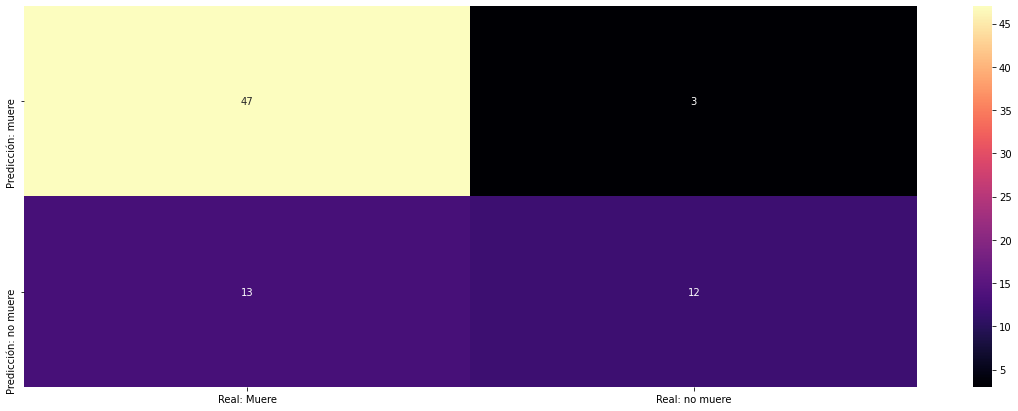

In [233]:
cm = confusion_matrix(y_test, y_preds_nb)

cm_matrix_nb = pd.DataFrame(data = cm, columns=['Real: Muere', 'Real: no muere'], 
                                 index=['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_nb, annot =True, cmap='magma', fmt='d');

In [234]:
print(classification_report(y_test, y_preds_nb))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.80      0.48      0.60        25

    accuracy                           0.79        75
   macro avg       0.79      0.71      0.73        75
weighted avg       0.79      0.79      0.77        75



In [235]:
scores = cross_val_score(classifier_nb, x_test, y_test, cv = 5, scoring='accuracy')
scores.mean()*100

84.00000000000001

# Arbol de decision

In [236]:
tree = DecisionTreeClassifier()
tree.fit(x_train_sc, y_train)
y_pred_test_tree = tree.predict(x_test_sc)

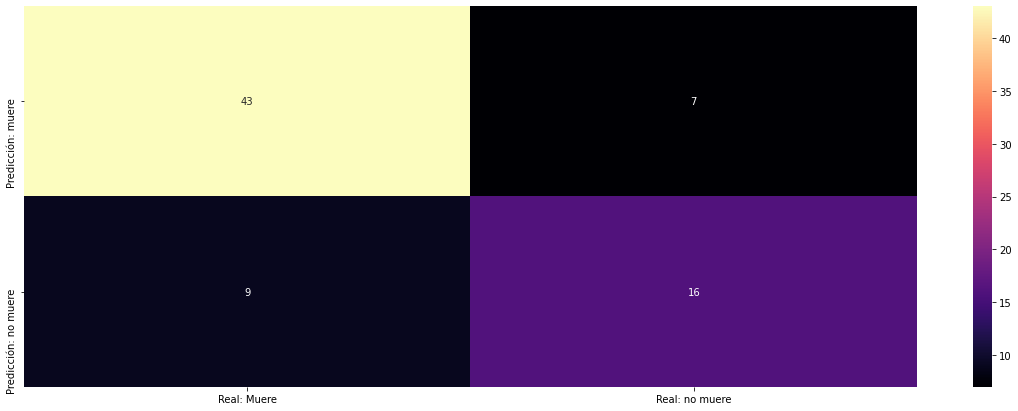

In [237]:
cm = confusion_matrix(y_test, y_pred_test_tree)

cm_matrix_tree = pd.DataFrame(data = cm, columns = ['Real: Muere', 'Real: no muere'], 
                                 index = ['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_tree, annot =True, cmap='magma', fmt='d');

In [238]:
print(classification_report(y_test, y_pred_test_tree))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        50
           1       0.70      0.64      0.67        25

    accuracy                           0.79        75
   macro avg       0.76      0.75      0.75        75
weighted avg       0.78      0.79      0.78        75



In [239]:
scores = cross_val_score(tree, x_test, y_test, cv = 5, scoring = 'accuracy')
scores.mean()*100

80.0

# Regresión logística

In [240]:
#regresion logistica con data normalizada
LR_sc = LogisticRegression(C=0.01, solver='liblinear')
LR_sc.fit(x_train_sc, y_train)
#predicciones
y_pred_test_lr = LR_sc.predict(x_test_sc)

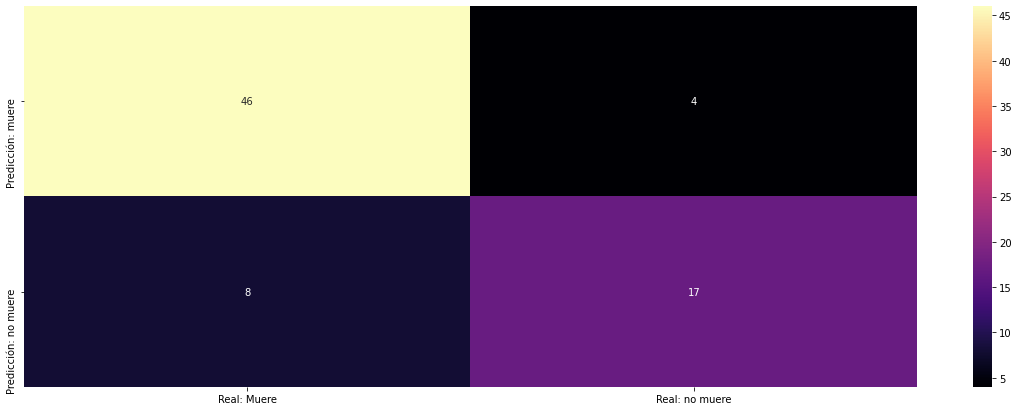

In [241]:
cm = confusion_matrix(y_test, y_pred_test_lr)

cm_matrix_lr = pd.DataFrame(data = cm, columns = ['Real: Muere', 'Real: no muere'], 
                                 index = ['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_lr, annot =True, cmap='magma', fmt='d');

In [242]:
print(classification_report(y_test, y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.81      0.68      0.74        25

    accuracy                           0.84        75
   macro avg       0.83      0.80      0.81        75
weighted avg       0.84      0.84      0.84        75



In [243]:
scores = cross_val_score(LR_sc, x_test_sc, y_test, cv = 5, scoring = 'accuracy')
scores.mean()*100

84.00000000000001

# Bosque Aleatorio

In [244]:
# Clasificador
classifier = RandomForestClassifier(n_estimators=100)
# Entrenamos con conjunto de entrenamiento
classifier.fit(x_train_sc, y_train) # x_train_n
#preds
y_pred_test_forest = classifier.predict(x_test_sc)

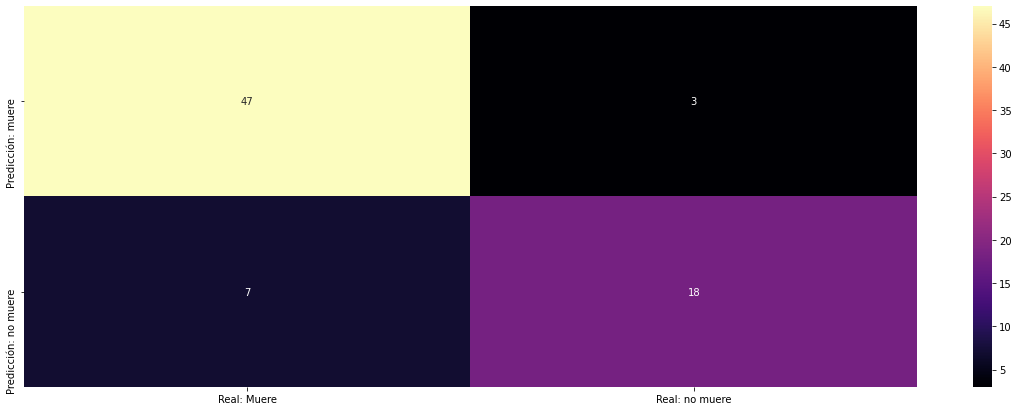

In [245]:
cm = confusion_matrix(y_test, y_pred_test_forest)

cm_matrix_forest = pd.DataFrame(data = cm, columns = ['Real: Muere', 'Real: no muere'], 
                                 index = ['Predicción: muere', 'Predicción: no muere'])

sns.heatmap(cm_matrix_forest, annot =True, cmap='magma', fmt='d');

In [246]:
print(classification_report(y_test, y_pred_test_forest))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        50
           1       0.86      0.72      0.78        25

    accuracy                           0.87        75
   macro avg       0.86      0.83      0.84        75
weighted avg       0.87      0.87      0.86        75



In [247]:
scores = cross_val_score(classifier, x_test_sc, y_test, cv = 5, scoring = 'accuracy')
scores.mean()*100

85.33333333333334

In [248]:
# Catacterísticas importantes
feature_importances_df = pd.DataFrame(
    {"feature": list(x_train_sc.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

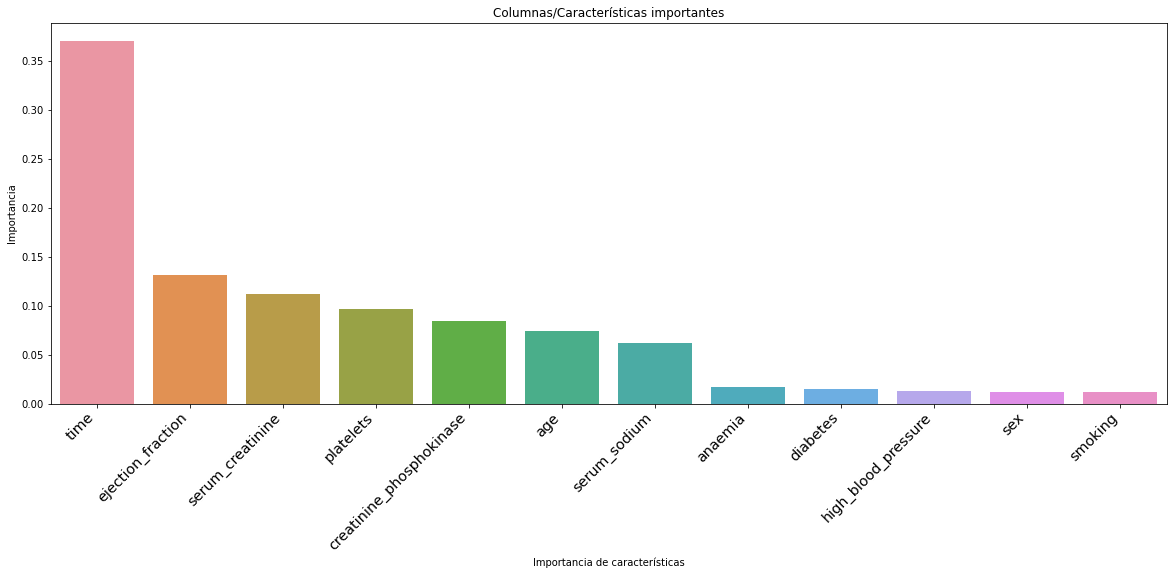

feature  importance
11                      time    0.369842
4          ejection_fraction    0.131750
7           serum_creatinine    0.112240
6                  platelets    0.096639
2   creatinine_phosphokinase    0.084322
0                        age    0.074307
8               serum_sodium    0.061988
1                    anaemia    0.017011
3                   diabetes    0.015248
5        high_blood_pressure    0.013447
9                        sex    0.011688
10                   smoking    0.011517

In [249]:
# Plot características importantes

# Gráfica de barras
sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)


plt.xlabel("Importancia de características")
plt.ylabel("Importancia")
plt.title("Columnas/Características importantes")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()
feature_importances_df

El sexo influye en las muertes????, podemos notar que no es un factor relevante

In [250]:
df[df['sex'] == 0]['DEATH_EVENT'].value_counts()

0    71
1    34
Name: DEATH_EVENT, dtype: int64

In [251]:
df[df['sex'] == 1]['DEATH_EVENT'].value_counts()

0    132
1     62
Name: DEATH_EVENT, dtype: int64

# Preprocesamiento de datos para la red

# Red neuronal

In [252]:
def build_model():
    model = keras.Sequential([
        layers.Dense(24, activation = "relu"),
        layers.Dense(48, activation = "relu"),
        layers.Dense(4, activation = "relu"), # cuello de botella 
        layers.Dense(1, activation = 'sigmoid') #activación lineal por default
    ])
    model.compile(optimizer = "rmsprop", 
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [347]:
m_1 = build_model()

callbacks = [
    keras.callbacks.ModelCheckpoint( #revisa la perdida
        filepath = "convnet_from_scratch.keras",
        save_best_only = True, #guarda el mejor modelo
        monitor = "val_loss") #monitoreal eval loss
]
red_simple = m_1.fit(x_train_sc, 
        y_train,
        epochs = 50, 
        batch_size = 13,
        validation_split = 0.2,
        callbacks = callbacks
        )

Epoch 1/50
14/14 [==============================] - 2s 38ms/step - loss: 0.6483 - accuracy: 0.6872 - val_loss: 0.5945 - val_accuracy: 0.6667
Epoch 2/50
14/14 [==============================] - 0s 21ms/step - loss: 0.5959 - accuracy: 0.6872 - val_loss: 0.5665 - val_accuracy: 0.6667
Epoch 3/50
14/14 [==============================] - 0s 19ms/step - loss: 0.5609 - accuracy: 0.6872 - val_loss: 0.5470 - val_accuracy: 0.6667
Epoch 4/50
14/14 [==============================] - 0s 18ms/step - loss: 0.5335 - accuracy: 0.6872 - val_loss: 0.5327 - val_accuracy: 0.6667
Epoch 5/50
14/14 [==============================] - 0s 21ms/step - loss: 0.5093 - accuracy: 0.6872 - val_loss: 0.5198 - val_accuracy: 0.6667
Epoch 6/50
14/14 [==============================] - 0s 20ms/step - loss: 0.4880 - accuracy: 0.6872 - val_loss: 0.5077 - val_accuracy: 0.6667
Epoch 7/50
14/14 [==============================] - 0s 20ms/step - loss: 0.4687 - accuracy: 0.7095 - val_loss: 0.5047 - val_accuracy: 0.6889
Epoch 8/50
14

In [348]:
m_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 24)                312       
                                                                 
 dense_58 (Dense)            (None, 48)                1200      
                                                                 
 dense_59 (Dense)            (None, 4)                 196       
                                                                 
 dense_60 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1,713
Trainable params: 1,713
Non-trainable params: 0
_________________________________________________________________


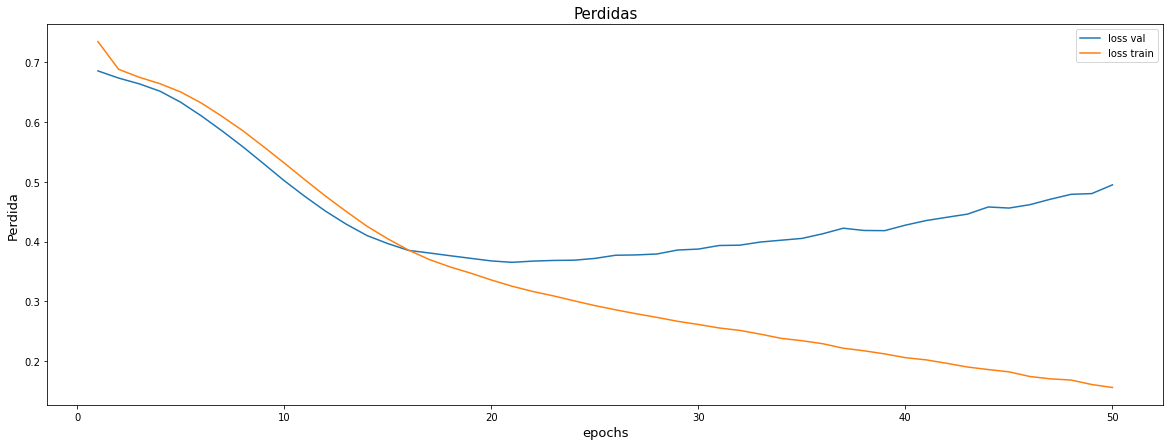

In [286]:
loss_val = red_simple.history['val_loss']
loss_train = red_simple.history['loss']

epochs = range(1, 51)

plt.plot(epochs, loss_val, label = "loss val")
plt.plot(epochs, loss_train, label = "loss train")

plt.title("Perdidas",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Perdida",fontsize=13)
plt.legend()
plt.show()

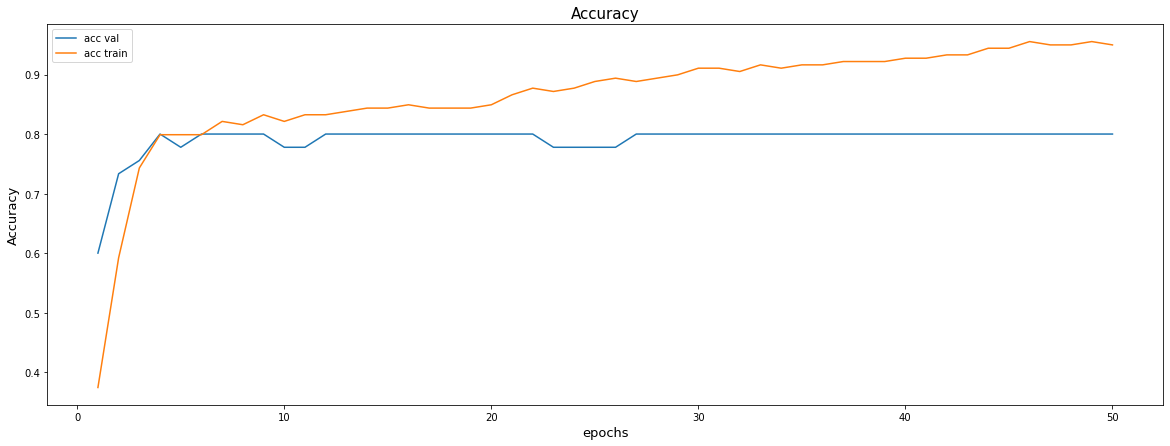

In [287]:
acc_val = red_simple.history['val_accuracy']
acc_train = red_simple.history['accuracy']

epochs = range(1, 51)

plt.plot(epochs, acc_val, label = "acc val")
plt.plot(epochs, acc_train, label = "acc train")

plt.title("Accuracy",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()

In [259]:
predictions = m_1.predict(x_test_sc)
a = predictions > 0.5
b = y_test == 1

a = a.reshape(75 ,)
c = (a == b)
c.value_counts(), c.value_counts()[1] / (c.value_counts()[1] + c.value_counts()[0])

(True     62
 False    13
 Name: DEATH_EVENT, dtype: int64,
 0.8266666666666667)

In [260]:
red_simple_preds = [1 if i > 0.5 else 0 for i in predictions]

In [261]:
print(classification_report(y_test, red_simple_preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.77      0.68      0.72        25

    accuracy                           0.83        75
   macro avg       0.81      0.79      0.80        75
weighted avg       0.82      0.83      0.82        75



# Matando Moscas con una bomba atómica?

### Preprocesamiento de datos para usarlos de forma matricial

In [263]:
# reshape de la data para meterla a un modelo de redes neuronales
x_train_net = []
for i in range(len(x_train_sc)):
    x_train_net.append(np.array(x_train_sc)[i].reshape(3,4))
    
x_test_net = []
for i in range(len(x_test_sc)):
    x_test_net.append(np.array(x_test_sc)[i].reshape(3,4))

In [266]:
x_train_net = np.array(x_train_net)
print(x_train_net.shape)
#test
x_test_net = np.array(x_test_net)
print(x_test_net.shape)

(224, 3, 4)
(75, 3, 4)


# Red sin Max pooling

In [336]:
inputs = keras.Input(shape=(3, 4, 1))
x = layers.Conv2D(filters = 24, kernel_size = 2, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 48, kernel_size = 1, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(filters = 24, kernel_size = 2, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(filters = 2, kernel_size = 1, activation="relu")(x) #cuello de botella
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_no_max_pool = keras.Model(inputs = inputs, outputs = outputs)

In [337]:
model_no_max_pool.compile(optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint( #revisa la perdida
        filepath = "convnet_from_scratch.keras",
        save_best_only = True, #guarda el mejor modelo
        monitor = "val_loss") #monitoreal eval loss
]


history_no_max_pool = model_no_max_pool.fit(x_train_net, 
                      y_train, 
                      epochs = 100, 
                      batch_size = 13,
                      validation_split = 0.2,
                      callbacks = callbacks                     
                                           )

Epoch 1/100
14/14 [==============================] - 2s 35ms/step - loss: 0.7113 - accuracy: 0.4637 - val_loss: 0.6663 - val_accuracy: 0.7556
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6690 - accuracy: 0.5698 - val_loss: 0.6510 - val_accuracy: 0.6667
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6705 - accuracy: 0.6034 - val_loss: 0.6431 - val_accuracy: 0.6667
Epoch 4/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6741 - accuracy: 0.6201 - val_loss: 0.6388 - val_accuracy: 0.6667
Epoch 5/100
14/14 [==============================] - 0s 21ms/step - loss: 0.6626 - accuracy: 0.6313 - val_loss: 0.6301 - val_accuracy: 0.6667
Epoch 6/100
14/14 [==============================] - 0s 23ms/step - loss: 0.6372 - accuracy: 0.6816 - val_loss: 0.6198 - val_accuracy: 0.6667
Epoch 7/100
14/14 [==============================] - 0s 25ms/step - loss: 0.6055 - accuracy: 0.6592 - val_loss: 0.6039 - val_accuracy: 0.6889
Epoch 

In [349]:
model_no_max_pool.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 3, 4, 1)]         0         
                                                                 
 conv2d_85 (Conv2D)          (None, 2, 3, 24)          120       
                                                                 
 dropout_56 (Dropout)        (None, 2, 3, 24)          0         
                                                                 
 conv2d_86 (Conv2D)          (None, 2, 3, 48)          1200      
                                                                 
 dropout_57 (Dropout)        (None, 2, 3, 48)          0         
                                                                 
 conv2d_87 (Conv2D)          (None, 1, 2, 24)          4632      
                                                                 
 dropout_58 (Dropout)        (None, 1, 2, 24)          0  

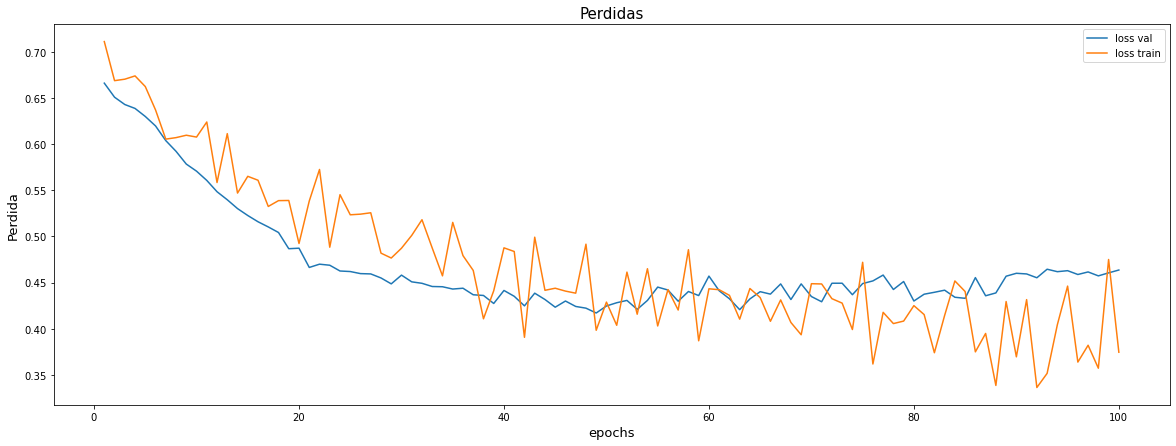

In [338]:
loss_val = history_no_max_pool.history['val_loss']
loss_train = history_no_max_pool.history['loss']

epochs = range(1, 101)

plt.plot(epochs, loss_val, label = "loss val")
plt.plot(epochs, loss_train, label = "loss train")

plt.title("Perdidas",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Perdida",fontsize=13)
plt.legend()
plt.show()

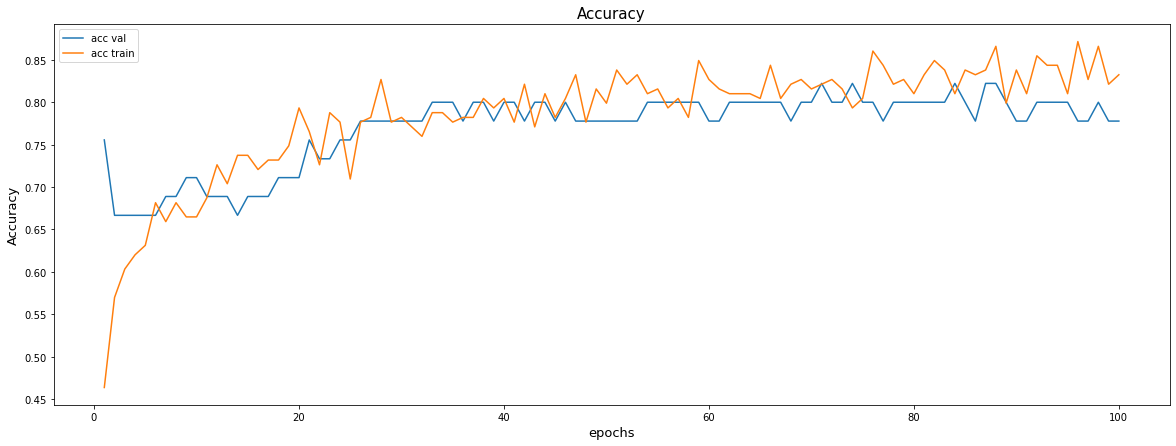

In [339]:
acc_val = history_no_max_pool.history['val_accuracy']
acc_train = history_no_max_pool.history['accuracy']

epochs = range(1, 101)

plt.plot(epochs, acc_val, label = "acc val")
plt.plot(epochs, acc_train, label = "acc train")

plt.title("Accuracy",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()

In [340]:
pred_no_max_pool = model_no_max_pool.predict(x_test_net)
red_no_max = [1 if i > 0.5 else 0 for i in pred_no_max_pool]
print(classification_report(y_test, red_no_max))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        50
           1       0.88      0.60      0.71        25

    accuracy                           0.84        75
   macro avg       0.85      0.78      0.80        75
weighted avg       0.85      0.84      0.83        75



# Red con Max pooling

Un kernel de tamaño uno (tamaña de filtro) un kernel de tamaño uno no le hace nada a los datos, el Kernel comun es uno de tamaño 2

Revisar la forma de las matrices

El max pooling extrae caracteristicas de la imagen (extrae el pixel maximo (promedio u otro) ), un max poolin de 2 disminuye la imagen en 2 dimensiones de lado

si la originas es de 3x4 y el maxpooling de 2 le quito toda la orilla 

- padding deja la imagen del tamaño original 

insertar padding en cada lote

investigar Convolucion de 1D

antes del maxpooling meter los paddings

In [326]:
# definicion de tamaño de las imagenes
inputs = keras.Input(shape = (3, 4, 1))

x = layers.Conv2D(filters = 24, kernel_size = 2, padding = 'same', strides = 2, activation = "relu")(inputs)
x = layers.MaxPooling2D(pool_size = 2)(x)
#x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters = 48, kernel_size = 2, padding = 'same', strides = 2, activation = "relu")(x) 
x = layers.MaxPooling2D(pool_size = 1)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters = 24, kernel_size = 2, padding = 'same', strides = 2, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 1 )(x)
#x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters = 2, kernel_size = 1, activation = "relu")(x)

x = layers.Flatten()(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)
model_pool = keras.Model(inputs = inputs, outputs = outputs)

In [327]:
model_pool.compile(optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

m_pool = model_pool.fit(x_train_net, 
                        y_train, 
                        epochs = 70, 
                        batch_size = 13,
                        validation_split = 0.2,
                        callbacks = callbacks
                       )

Epoch 1/70
14/14 [==============================] - 2s 35ms/step - loss: 0.6730 - accuracy: 0.6313 - val_loss: 0.6566 - val_accuracy: 0.6667
Epoch 2/70
14/14 [==============================] - 0s 11ms/step - loss: 0.6453 - accuracy: 0.6872 - val_loss: 0.6399 - val_accuracy: 0.6667
Epoch 3/70
14/14 [==============================] - 0s 11ms/step - loss: 0.6257 - accuracy: 0.6872 - val_loss: 0.6274 - val_accuracy: 0.6667
Epoch 4/70
14/14 [==============================] - 0s 11ms/step - loss: 0.6193 - accuracy: 0.6872 - val_loss: 0.6167 - val_accuracy: 0.6667
Epoch 5/70
14/14 [==============================] - 0s 12ms/step - loss: 0.6115 - accuracy: 0.6872 - val_loss: 0.6071 - val_accuracy: 0.6667
Epoch 6/70
14/14 [==============================] - 0s 11ms/step - loss: 0.6020 - accuracy: 0.6872 - val_loss: 0.5989 - val_accuracy: 0.6667
Epoch 7/70
14/14 [==============================] - 0s 11ms/step - loss: 0.6011 - accuracy: 0.6872 - val_loss: 0.5905 - val_accuracy: 0.6667
Epoch 8/70
14

In [350]:
model_pool.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 3, 4, 1)]         0         
                                                                 
 conv2d_77 (Conv2D)          (None, 2, 2, 24)          120       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 1, 1, 24)         0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 1, 1, 48)          4656      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 1, 1, 48)         0         
 g2D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 1, 1, 48)          0  

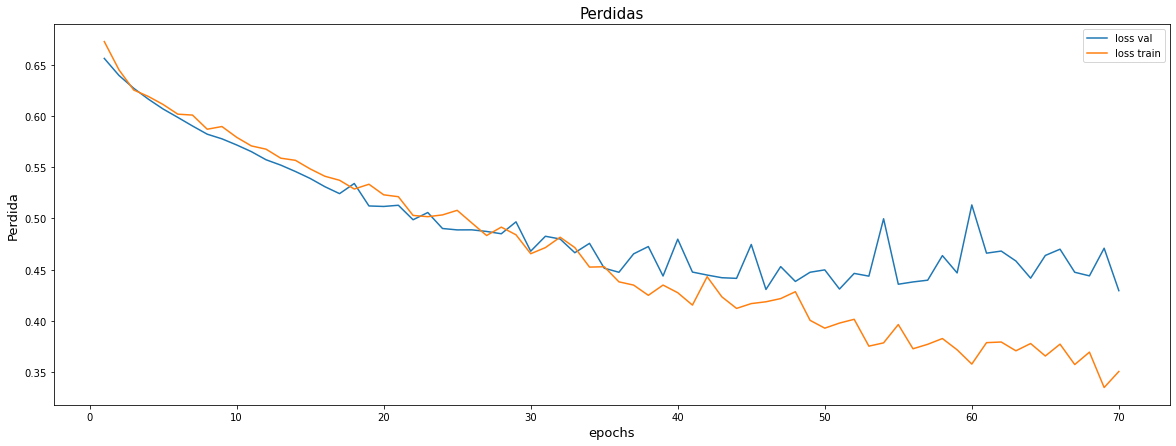

In [328]:
loss_val = m_pool.history['val_loss']
loss_train = m_pool.history['loss']

epochs = range(1, 71)

plt.plot(epochs, loss_val, label = "loss val")
plt.plot(epochs, loss_train, label = "loss train")

plt.title("Perdidas",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Perdida",fontsize=13)
plt.legend()
plt.show()

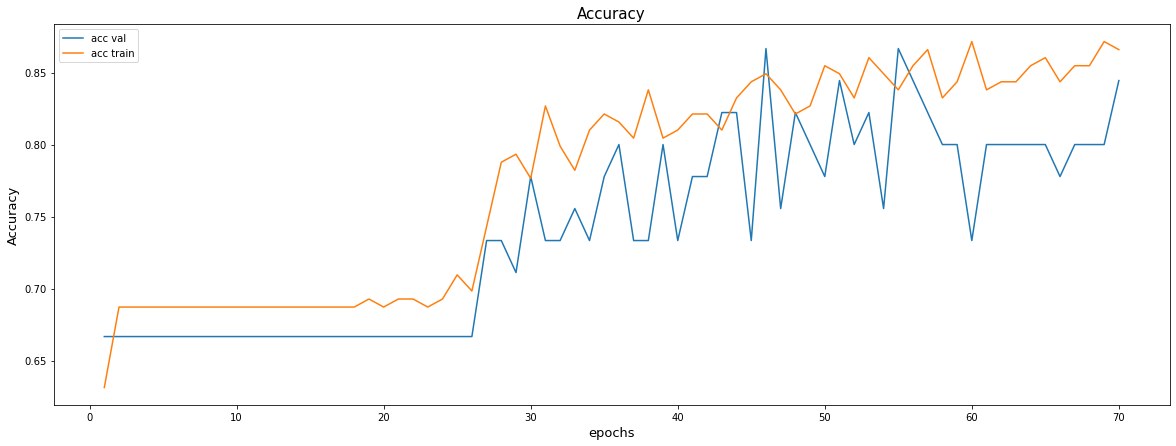

In [329]:
acc_val = m_pool.history['val_accuracy']
acc_train = m_pool.history['accuracy']

epochs = range(1, 71)

plt.plot(epochs, acc_val, label = "acc val")
plt.plot(epochs, acc_train, label = "acc train")

plt.title("Accuracy",fontsize=15)
plt.xlabel("epochs",fontsize=13)
plt.ylabel("Accuracy",fontsize=13)
plt.legend()
plt.show()

In [330]:
pred_max_pool = model_pool.predict(x_test_net)
red_max_pool = [1 if i > 0.5 else 0 for i in pred_max_pool]
print(classification_report(y_test, red_max_pool))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        50
           1       0.58      0.56      0.57        25

    accuracy                           0.72        75
   macro avg       0.68      0.68      0.68        75
weighted avg       0.72      0.72      0.72        75

